In [1]:
import pandas as pd
import numpy as np
dfcount = pd.read_csv("../../Additional_data/bloom_data/variant_counts.csv", 
                     usecols=['target', 'sample', 'barcode', 'count', 'aa_substitutions'],
                     low_memory=False)

In [2]:
dfcount = dfcount[(dfcount["sample"].str[:7] == 'TiteSeq') & (dfcount.target == "SARS-CoV-2")].copy()
omicron_mutations = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
omicron_mutations = [o[0] + str(int(o[1:-1]) - 330) + o[-1] for o in omicron_mutations]
omicron_mutations = set(omicron_mutations)
dfcount["is_omicron"] = dfcount.aa_substitutions.apply(lambda x: False if pd.isna(x) else set(x.split()).issubset(omicron_mutations)) 
dfcount = dfcount[dfcount.is_omicron]
dfcount["bin_number"] = dfcount["sample"].str[-1].apply(int)
dfcount["concentration"] = dfcount["sample"].str.extract(r'TiteSeq_(\d\d)_bin\d')
dfcount["concentration"] = dfcount.concentration.apply(int)
concentrations = np.array([-20, -13, -12.5, -12, -11.5, -11, -10.5, -10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5, -6][::-1])


In [3]:
barcodes_lst = dfcount.barcode.unique()
barcodes = dict(zip(barcodes_lst, range(len(barcodes_lst))))
barcodes_inv = dict(zip(range(len(barcodes_lst)), barcodes_lst))
cnts = np.zeros((len(barcodes), 4, 16))
for bc, cnt, bn, co in zip(dfcount.barcode, dfcount["count"], dfcount.bin_number, dfcount.concentration):
    cnts[barcodes[bc], bn-1, co-1] = cnt

In [4]:
import scipy.optimize

def extractKd(concentrations, bins_mean, bins_std):
    """
        Arguments: concentrations and exponential mean bin numbers (bin number: 1, 2, 3, 4)
        Return: -log10(Kd), and the r^2
    """
    popt, pcov = scipy.optimize.curve_fit(sigmoid, concentrations,
                                          bins_mean,
                                          p0=[-9., 2., 2.],
                                          sigma=bins_std, absolute_sigma=True,
                                          bounds=[(-14, 0, 0), (-5, 50000, 50000)],
                                          maxfev=400000)
    return(-1*popt[0], popt[1], popt[2], 1 - np.sum((sigmoid(concentrations, *popt) - bins_mean)**2)/np.sum((bins_mean - bins_mean.mean())**2), np.sqrt(np.diag(pcov))[0])

def sigmoid(c, Kd, A, B):
    return np.log10(A * (10**c/((10**c)+(10**Kd))) + B)


In [5]:
bins = np.array([1, 2, 3, 4])
Kds = {}
for s in range(cnts.shape[0]):
    bin_means = (cnts[s, :, :] * bins[:, None]).sum(axis=0)/(cnts[s, :, :].sum(axis=0))
    bin_means[~np.isfinite(bin_means)] = np.nan
    notnanindex = [ii for ii in range(16)
                if not np.isnan(bin_means[ii])]
  

    if len(notnanindex) < 4:
        Kds[s] = np.nan
    else:
        Kds[s] = extractKd(concentrations[notnanindex], bin_means[notnanindex], None)[0]
        
dfcount["Kd"] = dfcount.barcode.apply(lambda x: Kds[barcodes[x]])

/tmp/ipykernel_28917/1907513338.py:4: RuntimeWarning: invalid value encountered in true_divide
  bin_means = (cnts[s, :, :] * bins[:, None]).sum(axis=0)/(cnts[s, :, :].sum(axis=0))


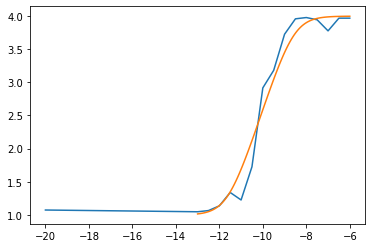

In [6]:
import matplotlib.pyplot as plt

s=40
bin_means = (cnts[s, :, :] * bins[:, None]).sum(axis=0)/(cnts[s, :, :].sum(axis=0))
bin_means[~np.isfinite(bin_means)] = np.nan
notnanindex = [ii for ii in range(16)
                if not np.isnan(bin_means[ii])]
plt.plot(concentrations, bin_means)
Kd, A, B, _, _ = extractKd(concentrations[notnanindex], bin_means[notnanindex], None)
xs = np.linspace(-13, -6, 100)
plt.plot(xs, [sigmoid(x, -Kd, A, B) for x in xs])

In [7]:
omicron_mutations = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
omicron_mutations = [o[0] + str(int(o[1:-1]) - 330) + o[-1] for o in omicron_mutations]
dfcount["geno"] = dfcount.aa_substitutions.apply(lambda x: 
                                                   "".join(["1" if i in [omicron_mutations.index(a) for a in x.split()]
                                                    else "0" for i in range(15)])
                                                  )
result_kds = dfcount.groupby("geno").agg({'Kd':['mean', 'std']})

In [8]:
dfus = pd.read_csv("../../Titeseq/results/Kds/cleaned_Kds_RBD_ACE2.tsv", sep="\t")
dfus["geno"] = dfus["geno"].apply(lambda x: f'{int(str(x),2):015b}')

In [9]:

dfus = dfus[dfus.geno.isin(result_kds.index)].copy()
dfus["log10Kd_tyler"] = dfus.geno.map(result_kds.Kd["mean"])
dfus["log10Kd_tyler_err"] = dfus.geno.map(result_kds.Kd["std"])

/home/thomas/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/thomas/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


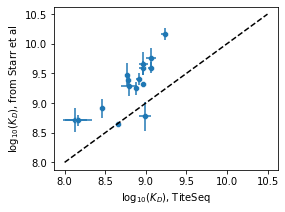

In [11]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(4, 3))
sns.scatterplot(x="log10Kd", y="log10Kd_tyler", data=dfus)
plt.errorbar(x="log10Kd", xerr='err_log10Kd', y="log10Kd_tyler",  yerr="log10Kd_tyler_err",data=dfus, ls='')
plt.plot([8, 10.5], [8, 10.5], color="k", ls="--")
plt.xlabel(r"$\log_{10}(K_D)$, TiteSeq")
plt.ylabel(r"$\log_{10}(K_D)$, from Starr et al")
plt.savefig("../Figures/SI_QC_E.pdf")

In [ ]:
concentrations